In [2]:
import os
import sys
import glob
import xarray as xr
import numpy as np
import arviz as az
import gsw
from pyddcurves.models import density_bhm_dht, double_tanh
from pyddcurves.utils import density_to_obsdict
from pyddcurves.utils import bhm_6_to_h5, plot_density_h5_step
from datatree import DataTree, open_datatree 
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter
import h5py

import warnings
warnings.filterwarnings("ignore")

from fastprogress import fastprogress
master_bar, progress_bar = fastprogress.force_console_behavior()
fastprogress.printing = lambda: True

# %matplotlib widget

In [46]:
moor_file = 'T150'
field_trip = 'RS2019'

# Set constants
varname = 'Temperature'
depthvar = 'z_nom'

# Set key data directories and outputs
project_root = r'/mnt/c/Users/00099894/Large_Data/'

# Get the Temp file
tree_in = glob.glob(os.path.join(project_root, field_trip, f'*{moor_file}*.nc'))

outname = f'{field_trip}_{moor_file}_Fitted_Buoyancy_Tonly_pydd.nc'
outfile = os.path.join(project_root, field_trip, outname)

In [47]:
ds = xr.open_dataset(tree_in[0])

temp = ds[varname]
temp = temp.interpolate_na(dim='z_nom', method='linear', max_gap=25)

# Remove data where all columns are NaN
temp = temp.dropna(dim='time', how='all')

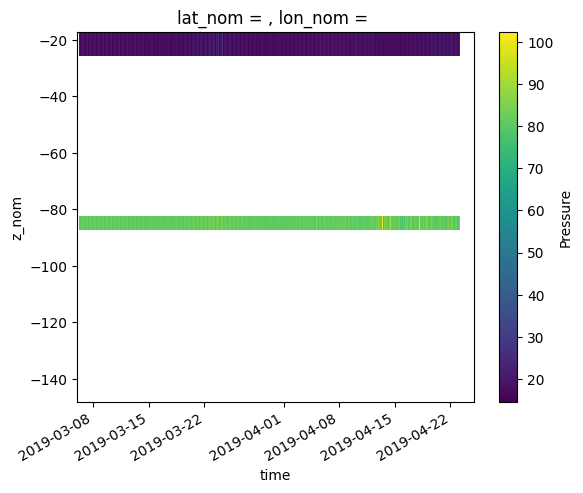

In [104]:
ds['Pressure'][:,::60].plot()

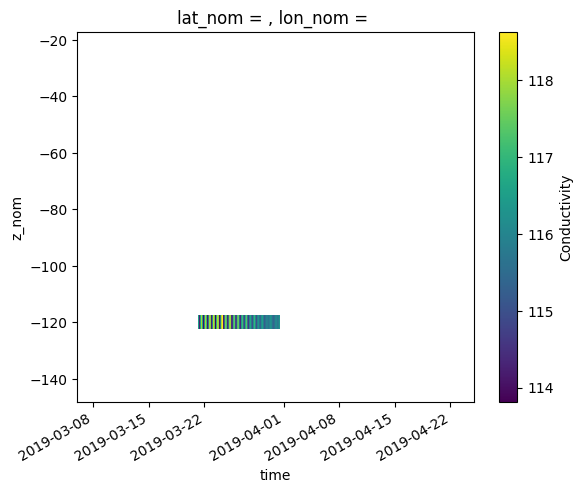

In [103]:
ds['Conductivity'][:,::60].plot()

In [48]:
# Run a 34-hour filter
import wootils.filters as fl

filt_low = 34
filt_high = None

temp = xr.apply_ufunc(fl.filter1d, temp, filt_low, 1, 'lowpass',\
                input_core_dims=[['time'],[],[],[]], output_core_dims=[['time']],\
                vectorize=True)

# Thin out temp data
temp = temp[:,::60]

## Estimate the salinity and pressure


In [63]:
# Time step
t_step = temp.time.diff(dim="time")[0].values.astype('timedelta64[s]')
slow_step = np.timedelta64(3, 'D')
nt_avg = (slow_step / t_step).astype(int)

print(f'Time step: {t_step}')
print(nt_avg)

Time step: 3600 seconds
72


In [64]:
n_times = len(temp['time']) / slow_step.astype(int)

S = 34.6*np.ones(temp.shape)
P = -ds['z_nom'].values[...,np.newaxis]*np.ones((1, len(temp['time'])))
rho_all = gsw.pot_rho_t_exact(S, temp, P, 0.).T

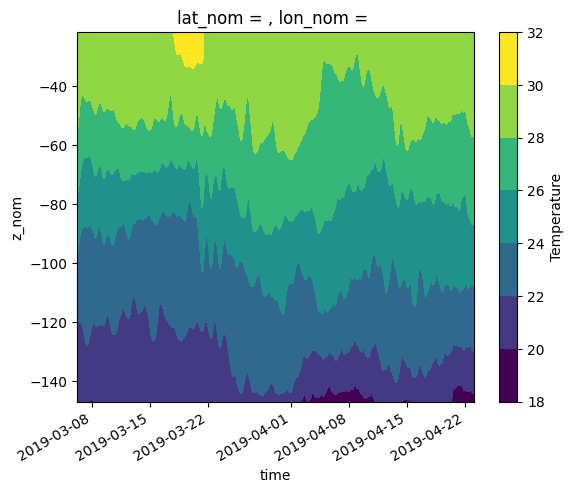

In [65]:
temp.plot.contourf()

In [66]:
# z2d = -1*np.tile(250 - ds['z_nom'].values, (int(n_times), 1))
z2d = np.tile(ds['z_nom'].values, (len(temp['time']), 1))
print(z2d[0,:])
print(z2d.shape)

[-147.1 -145.2 -143.  -141.  -139.  -137.  -135.  -133.  -131.  -129.
 -127.  -125.  -120.  -115.  -110.  -105.  -100.   -95.   -90.   -85.
  -80.   -70.   -60.   -50.   -30.   -21.5]
(1152, 26)


In [67]:
d_obs = density_to_obsdict(rho_all.values,
                            z2d,
                            temp['time'].values,
                            nt_avg,
                            np.std(z2d),
                            np.mean(rho_all.values),
                            np.std(rho_all.values))

In [68]:
d_obs

{'N': 29952,
 'n_times': 16,
 'rho': array([ 1.2391836 ,  1.20728883,  1.08378738, ..., -1.85534351,
        -2.19185869, -2.25315253]),
 'z': array([-4.14903051, -4.09544004, -4.03338792, ..., -1.4102755 ,
        -0.8461653 , -0.60641846]),
 'timeidx': array([ 0,  0,  0, ..., 15, 15, 15]),
 'rho_std': 0.7853380922740816,
 'rho_mu': 1023.2962517737219,
 'z_std': 35.45406562343406,
 'time': array([1551846060000000000, 1552105260000000000, 1552364460000000000,
        1552623660000000000, 1552882860000000000, 1553142060000000000,
        1553401260000000000, 1553660460000000000, 1553919660000000000,
        1554178860000000000, 1554438060000000000, 1554697260000000000,
        1554956460000000000, 1555215660000000000, 1555474860000000000,
        1555734060000000000]),
 'tdays': array([7004.18125, 7007.18125, 7010.18125, 7013.18125, 7016.18125,
        7019.18125, 7022.18125, 7025.18125, 7028.18125, 7031.18125,
        7034.18125, 7037.18125, 7040.18125, 7043.18125, 7046.18125,
        

In [69]:
import pymc as pm
import theano.tensor as tt

# Main Inference function
def density_bhm_dht(data, use_bhm=True, use_mcmc=True, 
            nchains=2, ncores=2, tune=2000, n_samp=2000):
    # Full model
    with pm.Model() as rho_model:
        ###
        # Create priors for each of our means
        # BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
        nparams=6
        nt = int(data['n_times'])

        # Priors on the means (assume everything is scaled to ~O(1) )
        if use_bhm:
            mu_beta_0 = pm.Normal('mu_beta_0', mu=1.0, sigma=1.0,)
            mu_beta_1 = pm.TruncatedNormal('mu_beta_1', mu=1., sigma=1., lower=0.0)
            mu_beta_3 = pm.TruncatedNormal('mu_beta_3', mu=1, sigma=1.0, lower=0.0)
            mu_beta_5 = pm.TruncatedNormal('mu_beta_5', mu=0, sigma=1.0, lower=0.0)
            mu_beta_mid = pm.TruncatedNormal('mu_beta_mid', mu=1., sigma=1.0, lower=0.0, shape=2,\
                                            initval=np.array([0.1,0.2]),\
                                            transform=pm.distributions.transforms.Ordered())

            #sigma_beta = pm.HalfNormal('sigma_beta', sd=1.0, shape=(nparams,))
            sigma_beta = pm.InverseGamma('sigma_beta', 1 , 1, shape=(nparams,))

        else:
            mu_beta_0 = 1
            mu_beta_1 = 1
            mu_beta_3 = 1
            mu_beta_5 = 1.
            mu_beta_6 = 0.
            mu_beta_mid = [0,1]
            sigma_beta=[1,1,1,1,1,1,1]

        #sigma_curve = pm.HalfNormal('sigma_curve', sd=2.0 )
        sigma_curve = pm.InverseGamma('sigma_curve', 1 , 1)

        beta_0 = pm.Normal('beta_0', mu=mu_beta_0, sigma=sigma_beta[0], shape=nt)
        beta_1 = pm.TruncatedNormal('beta_1', mu=mu_beta_1, sigma=sigma_beta[1], lower=0.0, shape=nt)
        beta_3 = pm.TruncatedNormal('beta_3', mu=mu_beta_3, sigma=sigma_beta[3], lower=0.0, shape=nt)    
        beta_2 = pm.TruncatedNormal('beta_2', mu=mu_beta_mid[0], sigma=sigma_beta[2], lower=0.0, shape=nt)
        beta_4 = pm.TruncatedNormal('beta_4', mu=mu_beta_mid[1], sigma=sigma_beta[4], lower=0.0, shape=nt)
        beta_5 = pm.TruncatedNormal('beta_5', mu=mu_beta_5, sigma=sigma_beta[5], lower=0.0, shape=nt)



        beta_s = [beta_0, beta_1, beta_2, beta_3, beta_4, beta_5, ]


        ###
        # Generate the likelihood function using the deterministic variable as the mean
        mu_x = double_tanh_pm(beta_s, data['timeidx'], data['z'])

        # shape parameter not requires as shape is specified in the priors...
        rho_out = pm.Normal('rho', mu=mu_x, sigma=sigma_curve, observed=data['rho'])
        
        ###
        # Inference step
        #trace = pm.sample(500)
        if use_mcmc:
            trace = pm.sample(n_samp, tune=tune, step=pm.NUTS(), cores=ncores, chains=nchains,\
                              compute_convergence_checks=False)

        else:
            # Use variational inference
            inference = pm.ADVI()
            approx = pm.fit(n=30000, method=inference)
            trace = approx.sample(draws=2000)
            
    
    return trace, rho_model

def double_tanh_pm(beta, timeidx, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2][timeidx])/beta[3][timeidx]
    fac2 = (z+beta[4][timeidx])/beta[5][timeidx]
    return beta[0][timeidx] - beta[1][timeidx]*( pm.math.tanh(fac1)
                + pm.math.tanh(fac2))

In [71]:
trace, rho_m = density_bhm_dht(d_obs, use_bhm=True, use_mcmc=True, 
                               nchains=2, ncores=2, tune=1000, n_samp=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_beta_0, mu_beta_1, mu_beta_3, mu_beta_5, mu_beta_mid, sigma_beta, sigma_curve, beta_0, beta_1, beta_3, beta_2, beta_4, beta_5]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7397 seconds.


In [81]:
trace.posterior

<xarray.Dataset>
Dimensions:            (chain: 2, draw: 1000, beta_0_dim_0: 16,
                        mu_beta_mid_dim_0: 2, sigma_beta_dim_0: 6,
                        beta_1_dim_0: 16, beta_3_dim_0: 16, beta_2_dim_0: 16,
                        beta_4_dim_0: 16, beta_5_dim_0: 16)
Coordinates:
  * chain              (chain) int64 0 1
  * draw               (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * beta_0_dim_0       (beta_0_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * mu_beta_mid_dim_0  (mu_beta_mid_dim_0) int64 0 1
  * sigma_beta_dim_0   (sigma_beta_dim_0) int64 0 1 2 3 4 5
  * beta_1_dim_0       (beta_1_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * beta_3_dim_0       (beta_3_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * beta_2_dim_0       (beta_2_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * beta_4_dim_0       (beta_4_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * beta_5_dim_0       (beta_5_dim_0) int64 0 1 2 3 4 5 6 ... 10 11 12 13 14 15
Data variables: (12/13)
    mu_beta_0          (chain, draw) float64 0.09328 0.0854 ... 0.2769 0.2085
    beta_0             (chain, draw, beta_0_dim_0) float64 0.676 ... 0.522
    mu_beta_1          (chain, draw) float64 1.594 1.607 1.605 ... 1.323 1.732
    mu_beta_3          (chain, draw) float64 1.237 1.015 ... 0.002899 0.02928
    mu_beta_5          (chain, draw) float64 0.1442 0.125 ... 0.4719 0.9534
    mu_beta_mid        (chain, draw, mu_beta_mid_dim_0) float64 0.1349 ... 1.579
    ...                 ...
    sigma_curve        (chain, draw) float64 0.0808 0.08089 ... 0.08126 0.0802
    beta_1             (chain, draw, beta_1_dim_0) float64 1.77 1.218 ... 1.701
    beta_3             (chain, draw, beta_3_dim_0) float64 1.096 ... 1.818
    beta_2             (chain, draw, beta_2_dim_0) float64 4.994 1.742 ... 2.005
    beta_4             (chain, draw, beta_4_dim_0) float64 1.754 3.497 ... 4.361
    beta_5             (chain, draw, beta_5_dim_0) float64 1.253 ... 0.9705
Attributes:
    created_at:                 2023-11-06T11:10:48.231097
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.6.1
    sampling_time:              7396.988106966019
    tuning_steps:               1000

In [92]:
arr = trace.posterior['beta_0'][0:1000,:].values
arr.reshape(-1, arr.shape[-1]).shape

(2000, 16)

In [93]:
def bhm_6_to_h5(outfile, trace, obsdata, use_bhm=True, nparams=6):
    # nsamples = len(trace)
    nsamples = len(trace['draw'].values)
    nsampleschain = len(trace['draw'].values) * trace['chain'].shape[0]
    nt = obsdata['n_times']
    
    # Convert the trace to a numpy array
    beta_samples = np.zeros((nparams,nt,nsampleschain))
    mu_beta_samples = np.zeros((nparams, nsampleschain))

    params = ['beta_0','beta_1','beta_2','beta_3','beta_4','beta_5']

    for ii in range(nparams):
        beta_samples[ii,...] = trace[params[ii]][0:nsamples,:].values.reshape(-1, arr.shape[-1]).T
        #mu_beta_samples[ii,...] = trace['mu_beta_%d'%ii][0:nsamples].T
    
    if use_bhm:
        # Convert the mean samples
        mu_beta_samples[0,...] = trace['mu_beta_0'][:,0:nsamples].values.flatten()
        mu_beta_samples[1,...] = trace['mu_beta_1'][:,0:nsamples].values.flatten()
        mu_beta_samples[3,...] = trace['mu_beta_3'][:,0:nsamples].values.flatten()
        mu_beta_samples[5,...] = trace['mu_beta_5'][:,0:nsamples].values.flatten()
        mu_beta_samples[2,...] = trace['mu_beta_mid'][:,0:nsamples,0].values.flatten()
        mu_beta_samples[4,...] = trace['mu_beta_mid'][:,0:nsamples,1].values.flatten()
    
    ###
    # Save to hdf5
    f = h5py.File(outfile,'w')
    f['beta_samples'] = beta_samples
    if use_bhm:
        f['mu_beta_samples'] = mu_beta_samples

    f['sigma_curve'] = trace['sigma_curve'][0:nsamples].values.flatten()
    f['sigma_beta'] = trace['sigma_beta'][0:nsamples,:].values.reshape(-1, arr.shape[-1]).T

    # Save all of the observed data into its own group
    g = f.create_group('data')

    for kk in obsdata.keys():
        g[kk] = obsdata[kk]

    print('Saved to %s with contents:'%outfile)
    print(f.name)
    for name in f:
        print('\t',name)

    print(g.name)
    for name in g:
        print('\t',name)

    f.close()

In [94]:
trace_name = 'RS2019_T150_3days'
bhm_6_to_h5(trace_name, trace.posterior, d_obs, use_bhm=True, nparams=6)

Saved to RS2019_T150_3days with contents:
/
	 beta_samples
	 data
	 mu_beta_samples
/data
	 N
	 n_times
	 rho
	 rho_mu
	 rho_std
	 tdays
	 time
	 timeidx
	 z
	 z_std


In [95]:
ixr = az.convert_to_dataset(trace)

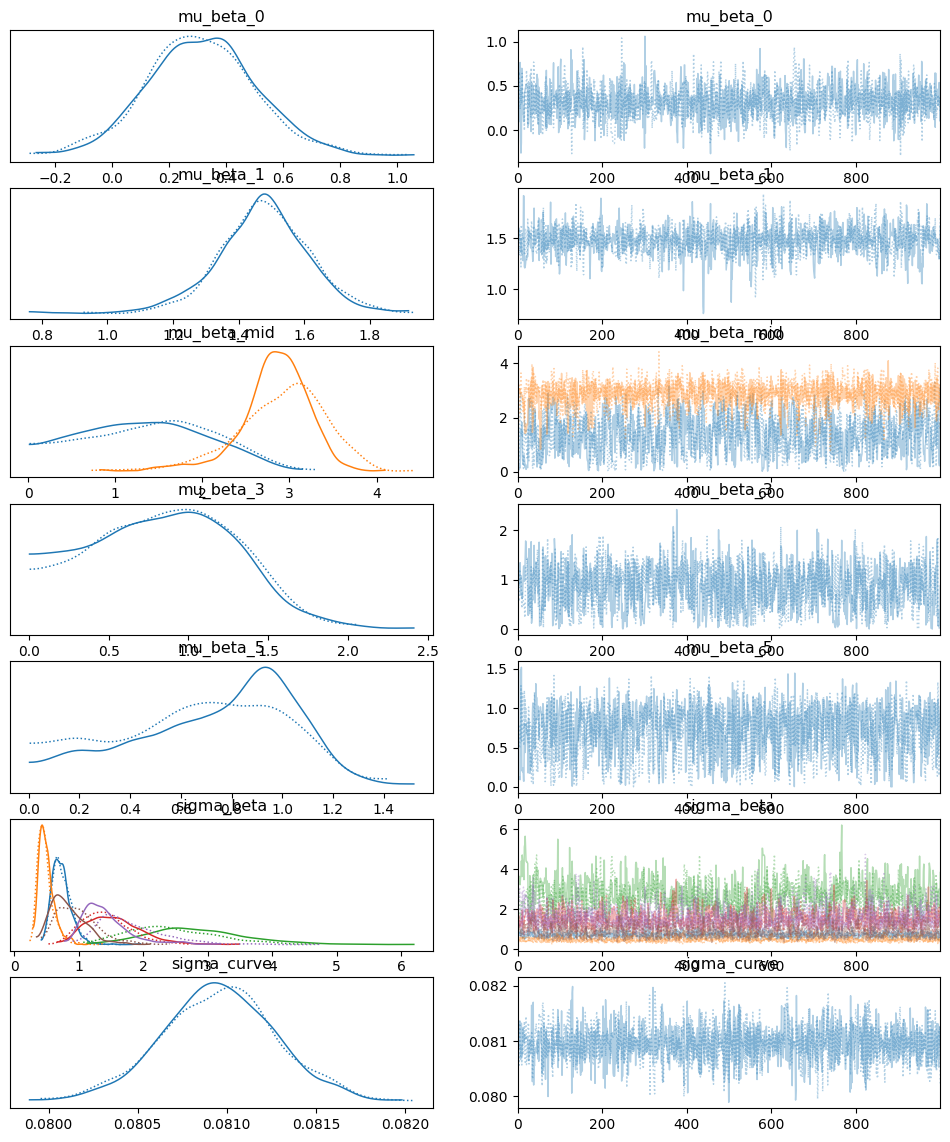

In [96]:
varlist = ['mu_beta_0', 'mu_beta_1', 'mu_beta_mid', 'mu_beta_3', 'mu_beta_5', 'sigma_beta', 'sigma_curve']
_=az.plot_trace(ixr, var_names=varlist)#, var_names=['mu_beta_' + str(ii) for ii in range(6)])

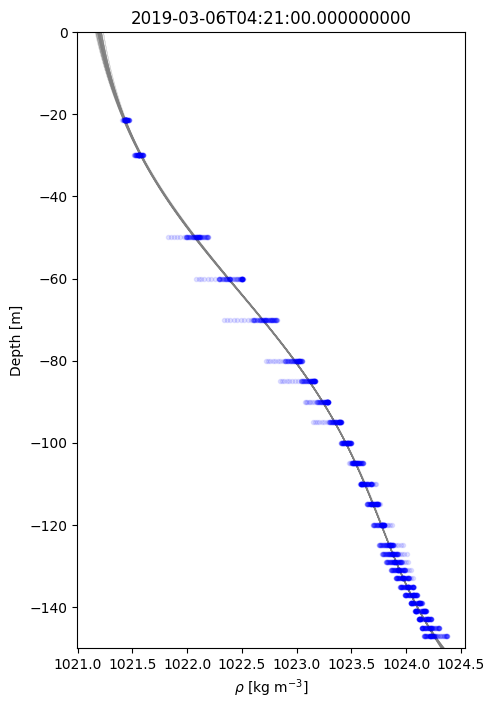

In [97]:
plot_density_h5_step(trace_name, 0, samples=100, zmin=-150)    

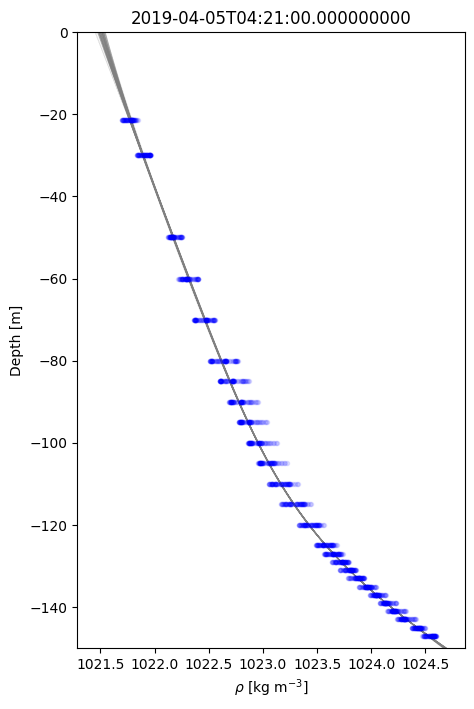

In [98]:
plot_density_h5_step(trace_name, 10, samples=100, zmin=-150)    

In [ ]:
# def sample_density(h5file, gridpoints=100, samples=100, zmin=-150):
#     """
#     Sample fitted density from trace file
#     """
    
#     with h5py.File(h5file,'r') as f:
        
#         data = f['/data']
#         time = data['time'][:]
#         z_std = data['z_std']
#         rho_std = data['rho_std']
#         rho_mu = data['rho_mu']
        
#         if zmin is None:
#             zmin = data['z'][:].min()*z_std
        
#         zout = np.linspace(zmin,0,gridpoints)
        
#         rhoall = np.zeros((len(time), len(zout), samples)).astype(float)
#         tstep = range(len(time))
#         nparams, nt, nsamples = f['beta_samples'].shape
        
#         if samples is None:
#             samples = nsamples

#         beta = f['beta_samples'][:]
        
#         for ix, rand_loc in enumerate(np.random.randint(0, nsamples, samples)):
#             for ts in tstep:
#                 rhotmp = double_tanh([beta[ii,ts,rand_loc] for ii in range(6)], zout/z_std)
#                 rhoall[ts,:,ix] = rhotmp*rho_std+rho_mu

#     return rhoall, zout, time

In [ ]:
# rhoall, zout, time = sample_density('test1', gridpoints=100, samples=100, zmin=-250)

(603, 100, 100)


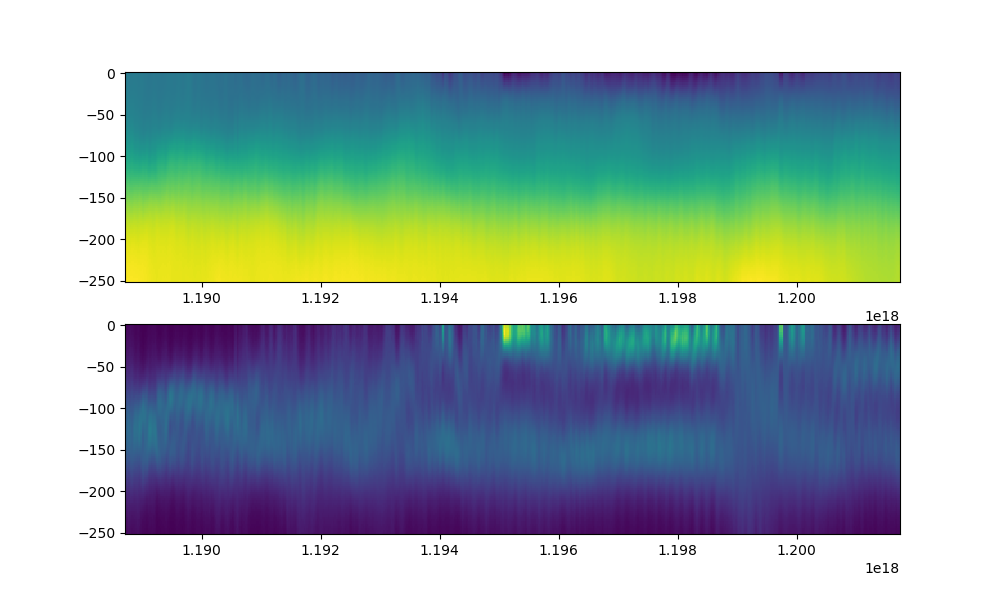

In [ ]:
# print(rhoall.shape)
# fig,ax=plt.subplots(2,1, figsize=(10,6))
# ax[0].pcolormesh(time, zout, np.median(rhoall, axis=-1).T)
# ax[1].pcolormesh(time, zout, -1*np.gradient(np.median(rhoall, axis=-1), axis=-1).T)